In [ ]:
# import libraries

import numpy                as np
import matplotlib.pyplot    as plt
import seaborn              as sns
import networkx             as nx
import math
import time
import pylatexenc

from matplotlib.animation   import FuncAnimation
from IPython.display        import HTML, display
from qiskit                 import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer             import Aer
from itertools              import combinations

In [ ]:
# visualization and results

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def visualize_graph(cost_matrix, title="TSP Graph"):
    n = len(cost_matrix)
    G = nx.complete_graph(n)
    pos = nx.circular_layout(G)

    plt.figure(figsize=(10, 8))

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

    edge_labels = {}
    for i in range(n):
        for j in range(i+1, n):
            edge_labels[(i, j)] = int(cost_matrix[i][j])

    nx.draw_networkx_edges(G, pos, alpha=0.3, width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_tour(cost_matrix, path, title="Optimal Tour", cost=None):
    n = len(cost_matrix)
    G = nx.complete_graph(n)
    pos = nx.circular_layout(G)

    fig, ax = plt.subplots(figsize=(12, 8))

    nx.draw_networkx_edges(G, pos, alpha=0.1, width=1, ax=ax)

    tour_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, tour_edges, edge_color='red', width=3, alpha=0.8, ax=ax)

    node_colors = ['lightgreen' if i == path[0] else 'lightblue' for i in range(n)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.9, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold', ax=ax)

    for idx, node in enumerate(path[:-1]):
        x, y = pos[node]
        ax.text(x, y-0.15, f"Step {idx}", fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

    edge_labels = {(path[i], path[i+1]): int(cost_matrix[path[i]][path[i+1]]) for i in range(len(path)-1)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=11, font_weight='bold', ax=ax)

    title_text = title
    if cost is not None: title_text += f"\nTotal Cost: {cost}"
    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def animate_tour(cost_matrix, path, interval=800):
    n = len(cost_matrix)
    G = nx.complete_graph(n)
    pos = nx.circular_layout(G)

    fig, ax = plt.subplots(figsize=(12, 8))

    def update(frame):
        ax.clear()

        nx.draw_networkx_edges(G, pos, alpha=0.1, width=1, ax=ax)

        if frame > 0:
            tour_edges = [(path[i], path[i+1]) for i in range(frame)]
            nx.draw_networkx_edges(G, pos, tour_edges, edge_color='red', width=3, alpha=0.8, ax=ax)

        node_colors = []
        for i in range(n):
            if i == path[0]:
                node_colors.append('lightgreen')
            elif frame > 0 and i == path[frame]:
                node_colors.append('orange')
            elif frame > 0 and i in path[:frame]:
                node_colors.append('lightcoral')
            else:
                node_colors.append('lightblue')

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.9, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold', ax=ax)

        cum_cost = sum(cost_matrix[path[i]][path[i+1]] for i in range(frame))

        ax.set_title(f"TSP Tour Animation - Step {frame}/{len(path)-1}\nCumulative Cost: {cum_cost}", fontsize=16, fontweight='bold')
        ax.axis('off')

    anim = FuncAnimation(fig, update, frames=len(path), interval=interval, repeat=True)
    plt.close()
    return anim

def visualize_dp_states(n_cities):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    subset_sizes = range(1, n_cities)
    num_states = [math.comb(n_cities-1, k) * k for k in subset_sizes]

    axes[0].bar(subset_sizes, num_states, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Subset Size', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of States', fontsize=12, fontweight='bold')
    axes[0].set_title('DP State Space Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    for i, (x, y) in enumerate(zip(subset_sizes, num_states)):
        axes[0].text(x, y, str(y), ha='center', va='bottom', fontweight='bold')

    total_states = sum(num_states)
    quantum_complexity = int(np.sqrt(total_states))

    methods = ['Classical\nExhaustive', 'Classical\nDP', 'Quantum\nDP']
    complexities = [math.factorial(n_cities), total_states, quantum_complexity]
    colors = ['red', 'orange', 'green']

    bars = axes[1].bar(methods, complexities, color=colors, alpha=0.7)
    axes[1].set_ylabel('Number of Operations (log scale)', fontsize=12, fontweight='bold')
    axes[1].set_title('Complexity Comparison', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log')
    axes[1].grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, val in zip(bars, complexities):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height, f'{val:,}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\nFor {n_cities} cities:")
    print(f"  Total DP states: {total_states:,}")
    print(f"  Classical complexity: O({total_states:,})")
    print(f"  Quantum complexity: O({quantum_complexity:,})")
    print(f"  Speedup factor: ~{total_states/quantum_complexity:.1f}x")

def create_quantum_oracle_example(n_qubits=3):
    qreg = QuantumRegister(n_qubits, 'q')
    qc = QuantumCircuit(qreg)

    qc.h(qreg)
    qc.barrier()

    qc.x(qreg[1])
    qc.h(qreg[2])
    qc.ccx(qreg[0], qreg[1], qreg[2])
    qc.h(qreg[2])
    qc.x(qreg[1])
    qc.barrier()

    qc.h(qreg)
    qc.x(qreg)
    qc.h(qreg[2])
    qc.ccx(qreg[0], qreg[1], qreg[2])
    qc.h(qreg[2])
    qc.x(qreg)
    qc.h(qreg)

    return qc

def visualize_quantum_circuit():
    qc = create_quantum_oracle_example()

    fig, ax = plt.subplots(figsize=(14, 6))
    qc.draw('mpl', ax=ax)
    plt.title("Grover Iteration", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    print("\nCircuit Components:")
    print("  1. Hadamard gates")
    print("  2. Oracle")
    print("  3. Diffusion")
    print(f"\nCircuit depth: {qc.depth()}")
    print(f"Gate count: {sum(qc.count_ops().values())}")

def visualize_qmf_results(stats):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    counts = stats['counts']
    bitstrings = list(counts.keys())
    values = [int(bs, 2) for bs in bitstrings]
    frequencies = list(counts.values())

    sorted_data = sorted(zip(values, frequencies))
    values, frequencies = zip(*sorted_data)

    colors = ['green' if v in stats['min_indices'] else 'steelblue' for v in values]

    axes[0].bar(values, frequencies, color=colors, alpha=0.7)
    axes[0].set_xlabel('State Index', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Measurement Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Quantum Measurement Results', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    stats['circuit'].draw('mpl', ax=axes[1])
    axes[1].set_title('Quantum Minimum Finding Circuit', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def compare_results(classical_result, quantum_result, cost_matrix):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    metrics = ['Time (s)', 'DP States', 'Operations']
    classical_vals = [
        classical_result['time'],
        classical_result['dp_states'],
        classical_result['operations']
    ]
    quantum_vals = [
        quantum_result['time'],
        quantum_result['dp_states'],
        quantum_result['quantum_calls'] + quantum_result['classical_calls']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    axes[0, 0].bar(x - width/2, classical_vals, width, label='Classical', alpha=0.8)
    axes[0, 0].bar(x + width/2, quantum_vals, width, label='Quantum', alpha=0.8)
    axes[0, 0].set_ylabel('Value', fontweight='bold')
    axes[0, 0].set_title('Performance Comparison', fontweight='bold', fontsize=14)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)

    labels = ['Quantum\nCalls', 'Classical\nCalls']
    sizes = [quantum_result['quantum_calls'], quantum_result['classical_calls']]
    colors = ['#ff9999', '#66b3ff']

    axes[0, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontweight': 'bold', 'fontsize': 11})
    axes[0, 1].set_title('Quantum vs Classical Subroutine Usage', fontweight='bold', fontsize=14)

    n = len(cost_matrix)
    G = nx.complete_graph(n)
    pos = nx.circular_layout(G)

    tour_edges = [(classical_result['path'][i], classical_result['path'][i+1]) for i in range(len(classical_result['path'])-1)]

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=600, ax=axes[1, 0])
    nx.draw_networkx_labels(G, pos, font_weight='bold', ax=axes[1, 0])
    nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[1, 0])
    nx.draw_networkx_edges(G, pos, tour_edges, edge_color='red', width=2, ax=axes[1, 0])
    axes[1, 0].set_title(f'Classical Solution\nCost: {classical_result["cost"]}', fontweight='bold', fontsize=14)
    axes[1, 0].axis('off')

    tour_edges = [(quantum_result['path'][i], quantum_result['path'][i+1]) for i in range(len(quantum_result['path'])-1)]

    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=600, ax=axes[1, 1])
    nx.draw_networkx_labels(G, pos, font_weight='bold', ax=axes[1, 1])
    nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[1, 1])
    nx.draw_networkx_edges(G, pos, tour_edges, edge_color='blue', width=2, ax=axes[1, 1])
    axes[1, 1].set_title(f'Quantum Solution\nCost: {quantum_result["cost"]}', fontweight='bold', fontsize=14)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("Summary:")
    print("="*60)
    print(f"\nClassical DP:")
    print(f"  Path: {classical_result['path']}")
    print(f"  Cost: {classical_result['cost']}")
    print(f"  Time: {classical_result['time']:.4f}s")
    print(f"  Operations: {classical_result['operations']:,}")

    print(f"\nQuantum-Enhanced DP:")
    print(f"  Path: {quantum_result['path']}")
    print(f"  Cost: {quantum_result['cost']}")
    print(f"  Time: {quantum_result['time']:.4f}s")
    print(f"  Quantum calls: {quantum_result['quantum_calls']}")
    print(f"  Classical calls: {quantum_result['classical_calls']}")

    print(f"\nVerification:")
    if classical_result['cost'] == quantum_result['cost']:
        print("  ✓ Both methods found the same optimal solution!")
    else:
        print("  ⚠ Solutions differ - quantum may need more shots")


In [ ]:
# quantum minimum finding implementation

class QuantumMinimumFinder:
    def __init__(self, backend='qasm_simulator', shots=1024):
        self.backend = Aer.get_backend(backend)
        self.shots = shots

    def find_minimum(self, cost_function, search_space_size):
        if search_space_size == 0: return None, {}

        costs = [cost_function(i) for i in range(search_space_size)]
        min_cost = min(costs)
        min_indices = [i for i, c in enumerate(costs) if c == min_cost]

        n_qubits = math.ceil(math.log2(max(search_space_size, 2)))

        qreg = QuantumRegister(n_qubits, 'search')
        creg = ClassicalRegister(n_qubits, 'result')
        qc = QuantumCircuit(qreg, creg)

        qc.h(qreg)

        n_iterations = int(np.pi / 4 * np.sqrt(search_space_size / len(min_indices)))
        n_iterations = max(1, n_iterations)

        for _ in range(n_iterations):
            for idx in min_indices:
                if idx < 2**n_qubits:
                    binary = format(idx, f'0{n_qubits}b')
                    for i, bit in enumerate(binary):
                        if bit == '0': qc.x(qreg[i])

                    if n_qubits > 1:
                        qc.h(qreg[-1])
                        qc.mcx(qreg[:-1], qreg[-1])
                        qc.h(qreg[-1])
                    else:
                        qc.z(qreg[0])

                    for i, bit in enumerate(binary):
                        if bit == '0':
                            qc.x(qreg[i])

            qc.h(qreg)
            qc.x(qreg)
            if n_qubits > 1:
                qc.h(qreg[-1])
                qc.mcx(qreg[:-1], qreg[-1])
                qc.h(qreg[-1])
            else:
                qc.z(qreg[0])
            qc.x(qreg)
            qc.h(qreg)

        qc.measure(qreg, creg)

        result = self.backend.run(qc, shots=self.shots).result()
        counts = result.get_counts()

        max_count = 0
        best_result = 0
        for bitstring, count in counts.items():
            value = int(bitstring, 2)
            if value < search_space_size and count > max_count:
                max_count = count
                best_result = value

        stats = {
            'counts': counts,
            'circuit': qc,
            'iterations': n_iterations,
            'search_space': search_space_size,
            'min_indices': min_indices,
            'success_probability': max_count / self.shots
        }

        return best_result, stats

In [ ]:
# classical dp solver

class ClassicalTSPSolver:
    def __init__(self, cost_matrix):
        self.cost_matrix = np.array(cost_matrix)
        self.n = len(cost_matrix)
        self.dp_table = {}
        self.parent = {}
        self.call_count = 0

    def solve(self):
        start_time = time.time()
        self.call_count = 0

        for i in range(1, self.n):
            self.dp_table[(1 << i, i)] = self.cost_matrix[0][i]
            self.parent[(1 << i, i)] = 0
            self.call_count += 1

        for size in range(2, self.n):
            for subset in combinations(range(1, self.n), size):
                bits = sum(1 << i for i in subset)
                for last in subset:
                    prev_bits = bits & ~(1 << last)
                    min_cost = float('inf')
                    min_prev = -1

                    for prev in subset:
                        if prev != last:
                            prev_state = (prev_bits, prev)
                            if prev_state in self.dp_table:
                                cost = self.dp_table[prev_state] + self.cost_matrix[prev][last]
                                self.call_count += 1
                                if cost < min_cost:
                                    min_cost = cost
                                    min_prev = prev

                    if min_prev != -1:
                        self.dp_table[(bits, last)] = min_cost
                        self.parent[(bits, last)] = min_prev

        all_cities = (1 << self.n) - 2
        min_cost = float('inf')
        last_city = -1

        for i in range(1, self.n):
            state = (all_cities, i)
            if state in self.dp_table:
                cost = self.dp_table[state] + self.cost_matrix[i][0]
                if cost < min_cost:
                    min_cost = cost
                    last_city = i

        path = self._reconstruct_path(last_city, all_cities)

        solve_time = time.time() - start_time

        return {
            'path': path,
            'cost': min_cost,
            'time': solve_time,
            'dp_states': len(self.dp_table),
            'operations': self.call_count
        }

    def _reconstruct_path(self, last_city, all_cities):
        if last_city == -1:
            return None

        path = [0]
        bits = all_cities
        current = last_city

        while bits:
            path.append(current)
            prev = self.parent.get((bits, current), -1)
            if prev == -1:
                break
            bits &= ~(1 << current)
            current = prev

        path.append(0)
        path.reverse()

        return path

In [ ]:
# quantum enhanced dp solver

class QuantumTSPSolver:
    def __init__(self, cost_matrix, use_quantum_threshold=4):
        self.cost_matrix = np.array(cost_matrix)
        self.n = len(cost_matrix)
        self.dp_table = {}
        self.parent = {}
        self.qmf = QuantumMinimumFinder()
        self.use_quantum_threshold = use_quantum_threshold
        self.quantum_calls = 0
        self.classical_calls = 0

    def solve(self):
        start_time = time.time()

        for i in range(1, self.n):
            self.dp_table[(1 << i, i)] = self.cost_matrix[0][i]
            self.parent[(1 << i, i)] = 0

        for size in range(2, self.n):
            for subset in combinations(range(1, self.n), size):
                bits = sum(1 << i for i in subset)

                for last in subset:
                    prev_bits = bits & ~(1 << last)
                    valid_prevs = [p for p in subset if p != last]

                    if not valid_prevs: continue

                    def cost_function(idx):
                        if idx >= len(valid_prevs):
                            return float('inf')
                        prev = valid_prevs[idx]
                        prev_state = (prev_bits, prev)
                        if prev_state not in self.dp_table:
                            return float('inf')
                        return self.dp_table[prev_state] + self.cost_matrix[prev][last]

                    if len(valid_prevs) > self.use_quantum_threshold:
                        min_idx, _ = self.qmf.find_minimum(cost_function, len(valid_prevs))
                        min_prev = valid_prevs[min_idx]
                        min_cost = cost_function(min_idx)
                        self.quantum_calls += 1
                    else:
                        min_cost = float('inf')
                        min_prev = -1
                        for idx, prev in enumerate(valid_prevs):
                            cost = cost_function(idx)
                            if cost < min_cost:
                                min_cost = cost
                                min_prev = prev
                        self.classical_calls += 1

                    if min_prev != -1 and min_cost != float('inf'):
                        self.dp_table[(bits, last)] = min_cost
                        self.parent[(bits, last)] = min_prev

        all_cities = (1 << self.n) - 2
        min_cost = float('inf')
        last_city = -1

        for i in range(1, self.n):
            state = (all_cities, i)
            if state in self.dp_table:
                cost = self.dp_table[state] + self.cost_matrix[i][0]
                if cost < min_cost:
                    min_cost = cost
                    last_city = i

        path = self._reconstruct_path(last_city, all_cities)

        solve_time = time.time() - start_time

        return {
            'path': path,
            'cost': min_cost,
            'time': solve_time,
            'dp_states': len(self.dp_table),
            'quantum_calls': self.quantum_calls,
            'classical_calls': self.classical_calls
        }

    def _reconstruct_path(self, last_city, all_cities):
        if last_city == -1: return None

        path = [0]
        bits = all_cities
        current = last_city

        while bits:
            path.append(current)
            prev = self.parent.get((bits, current), -1)
            if prev == -1:
                break
            bits &= ~(1 << current)
            current = prev

        path.append(0)
        path.reverse()

        return path

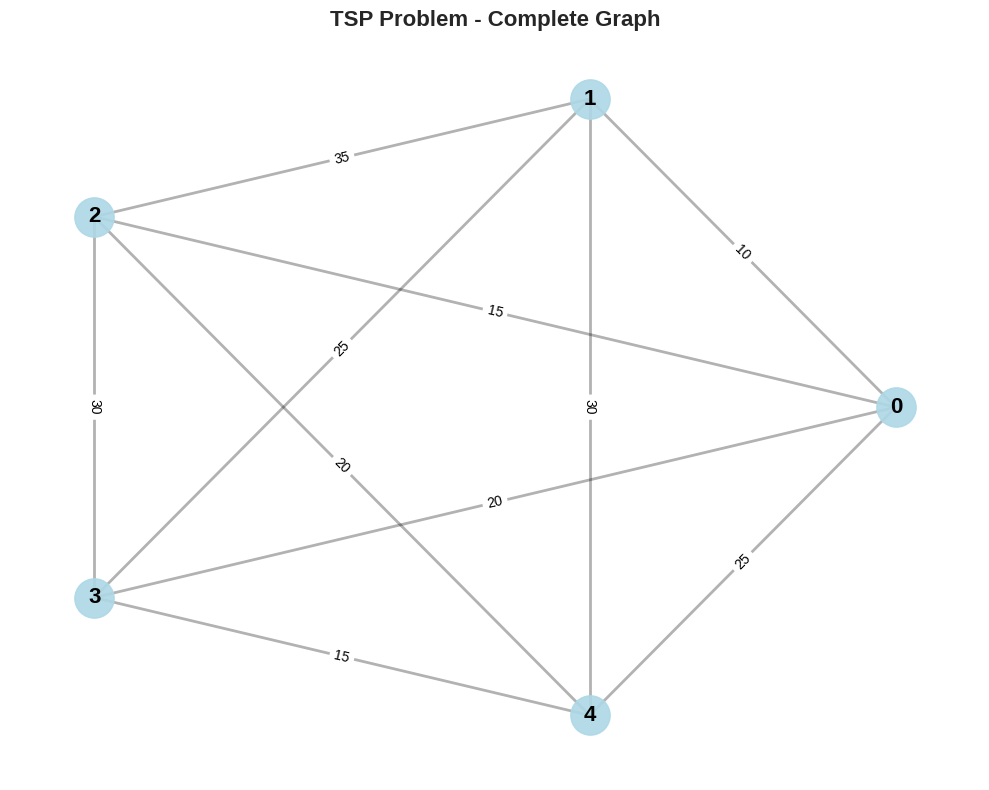

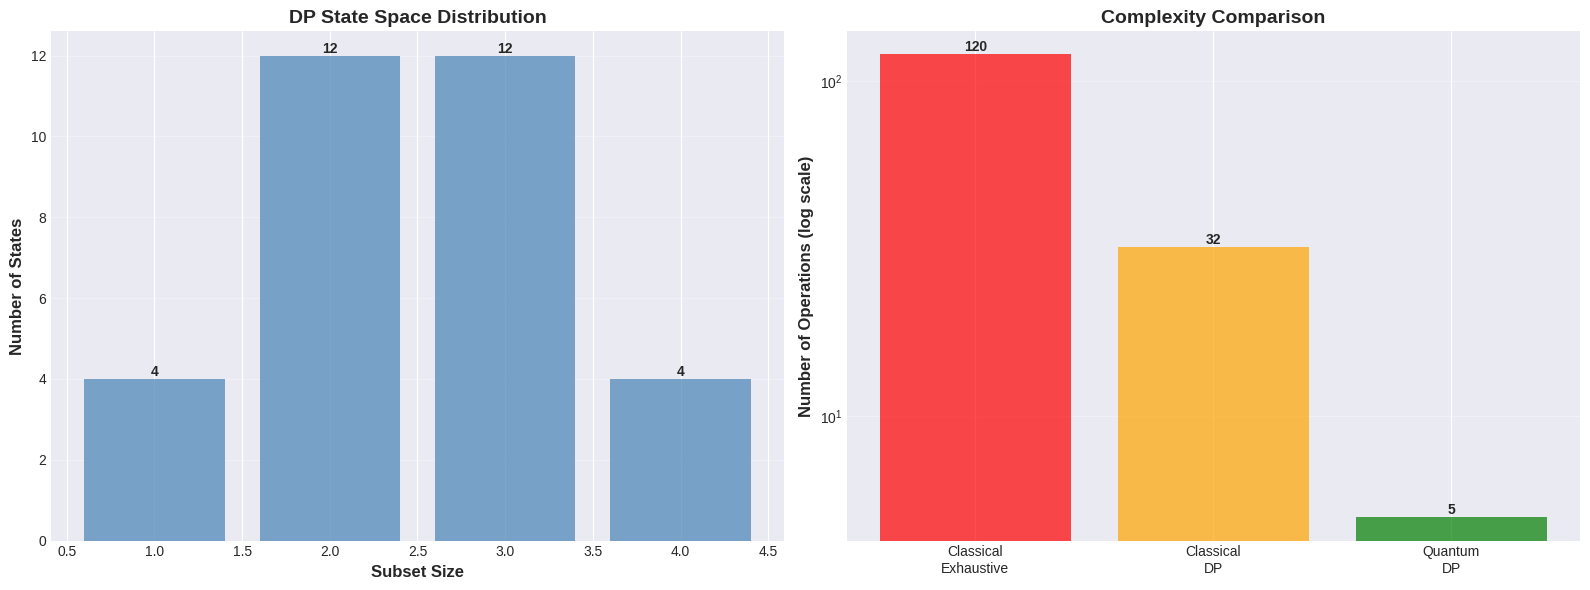


For 5 cities:
  Total DP states: 32
  Classical complexity: O(32)
  Quantum complexity: O(5)
  Speedup factor: ~6.4x


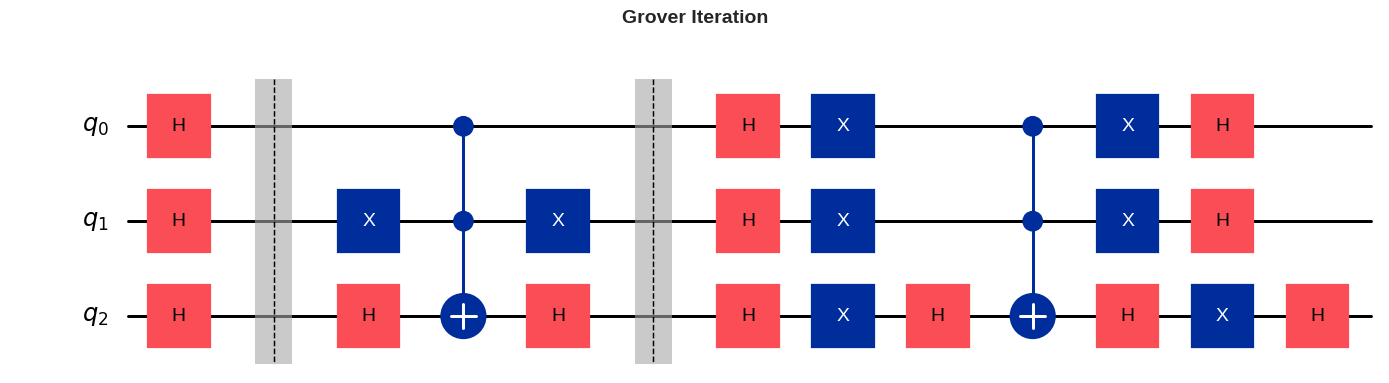


Circuit Components:
  1. Hadamard gates
  2. Oracle
  3. Diffusion

Circuit depth: 11
Gate count: 25


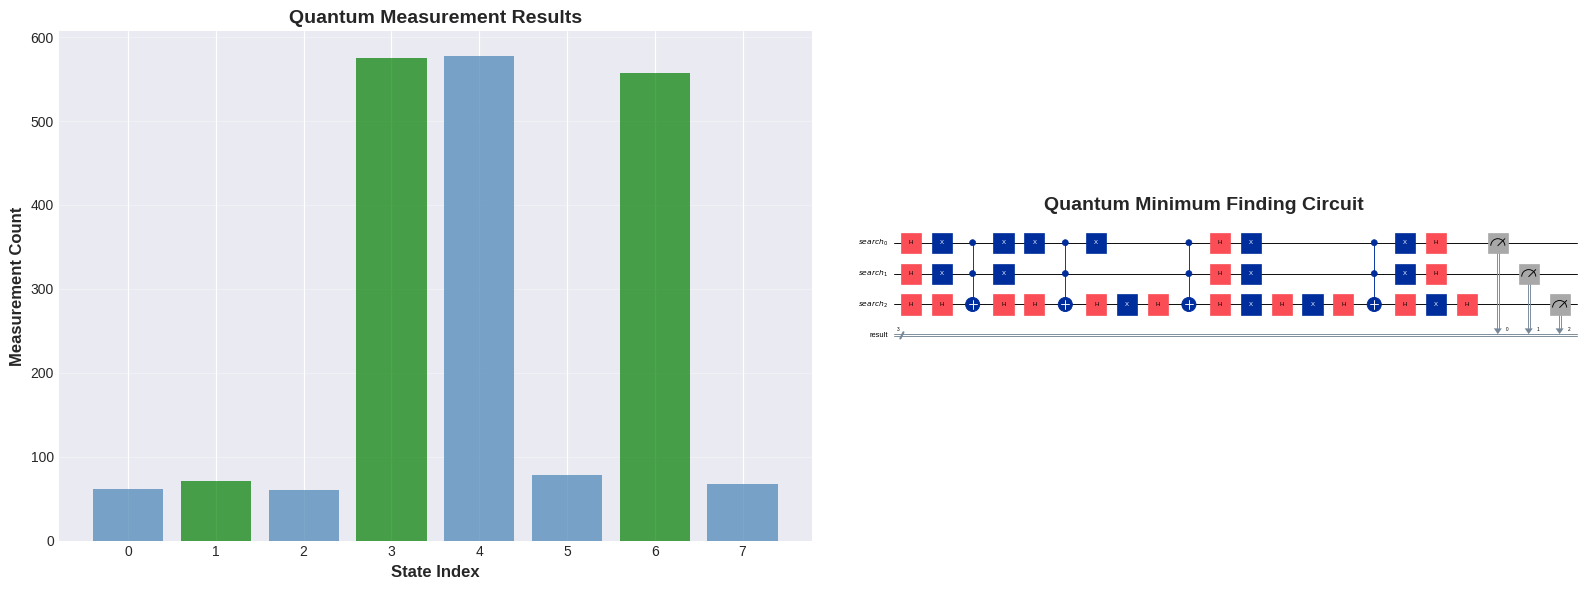

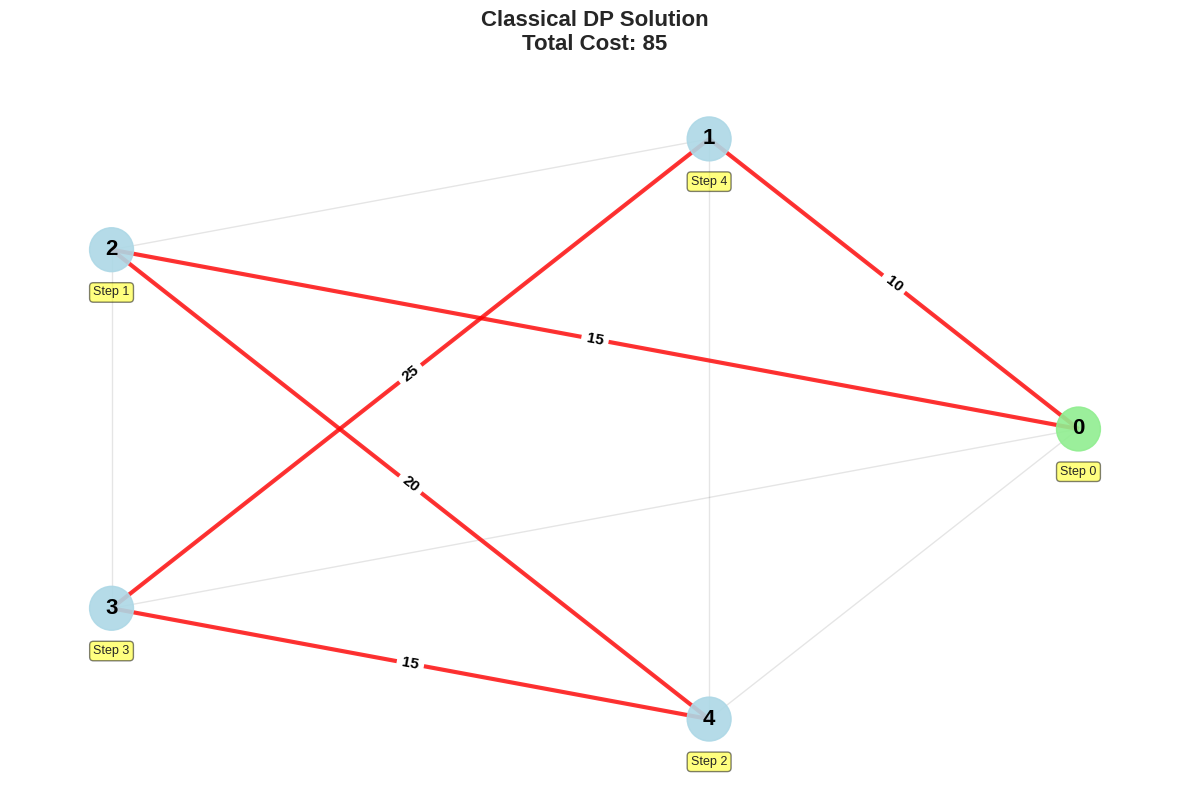

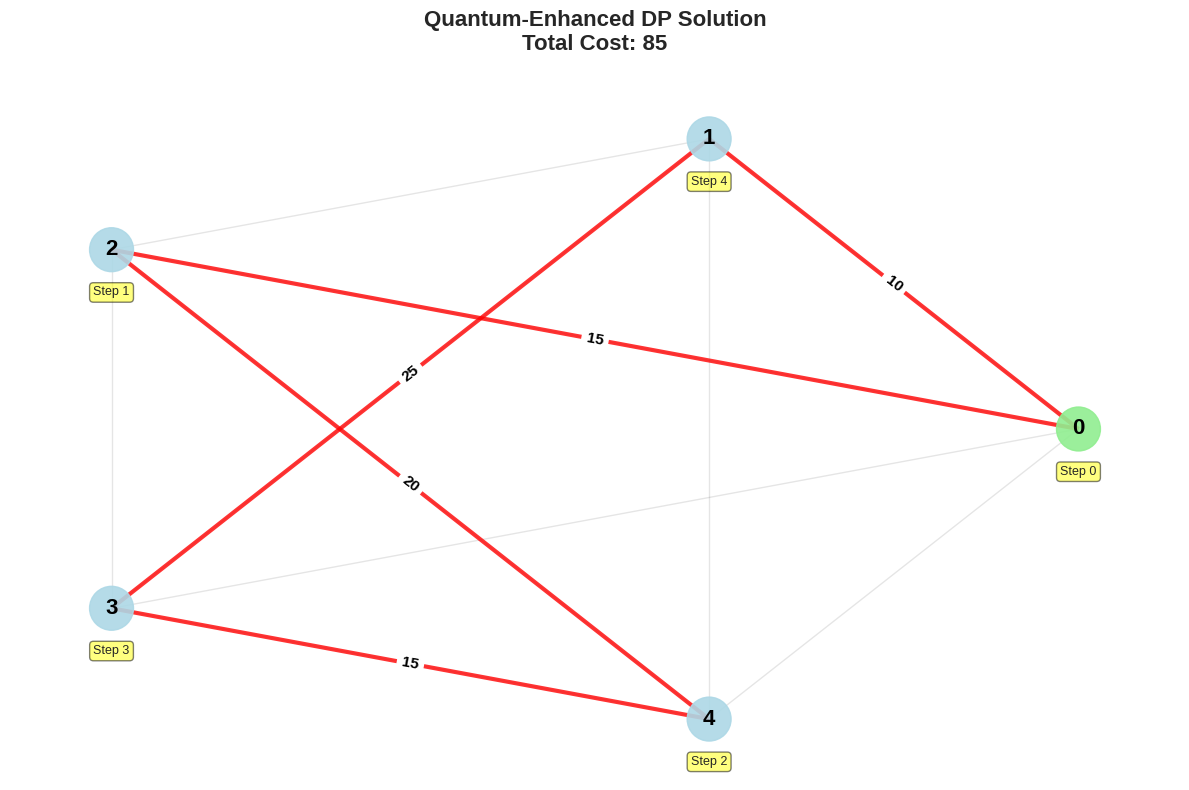

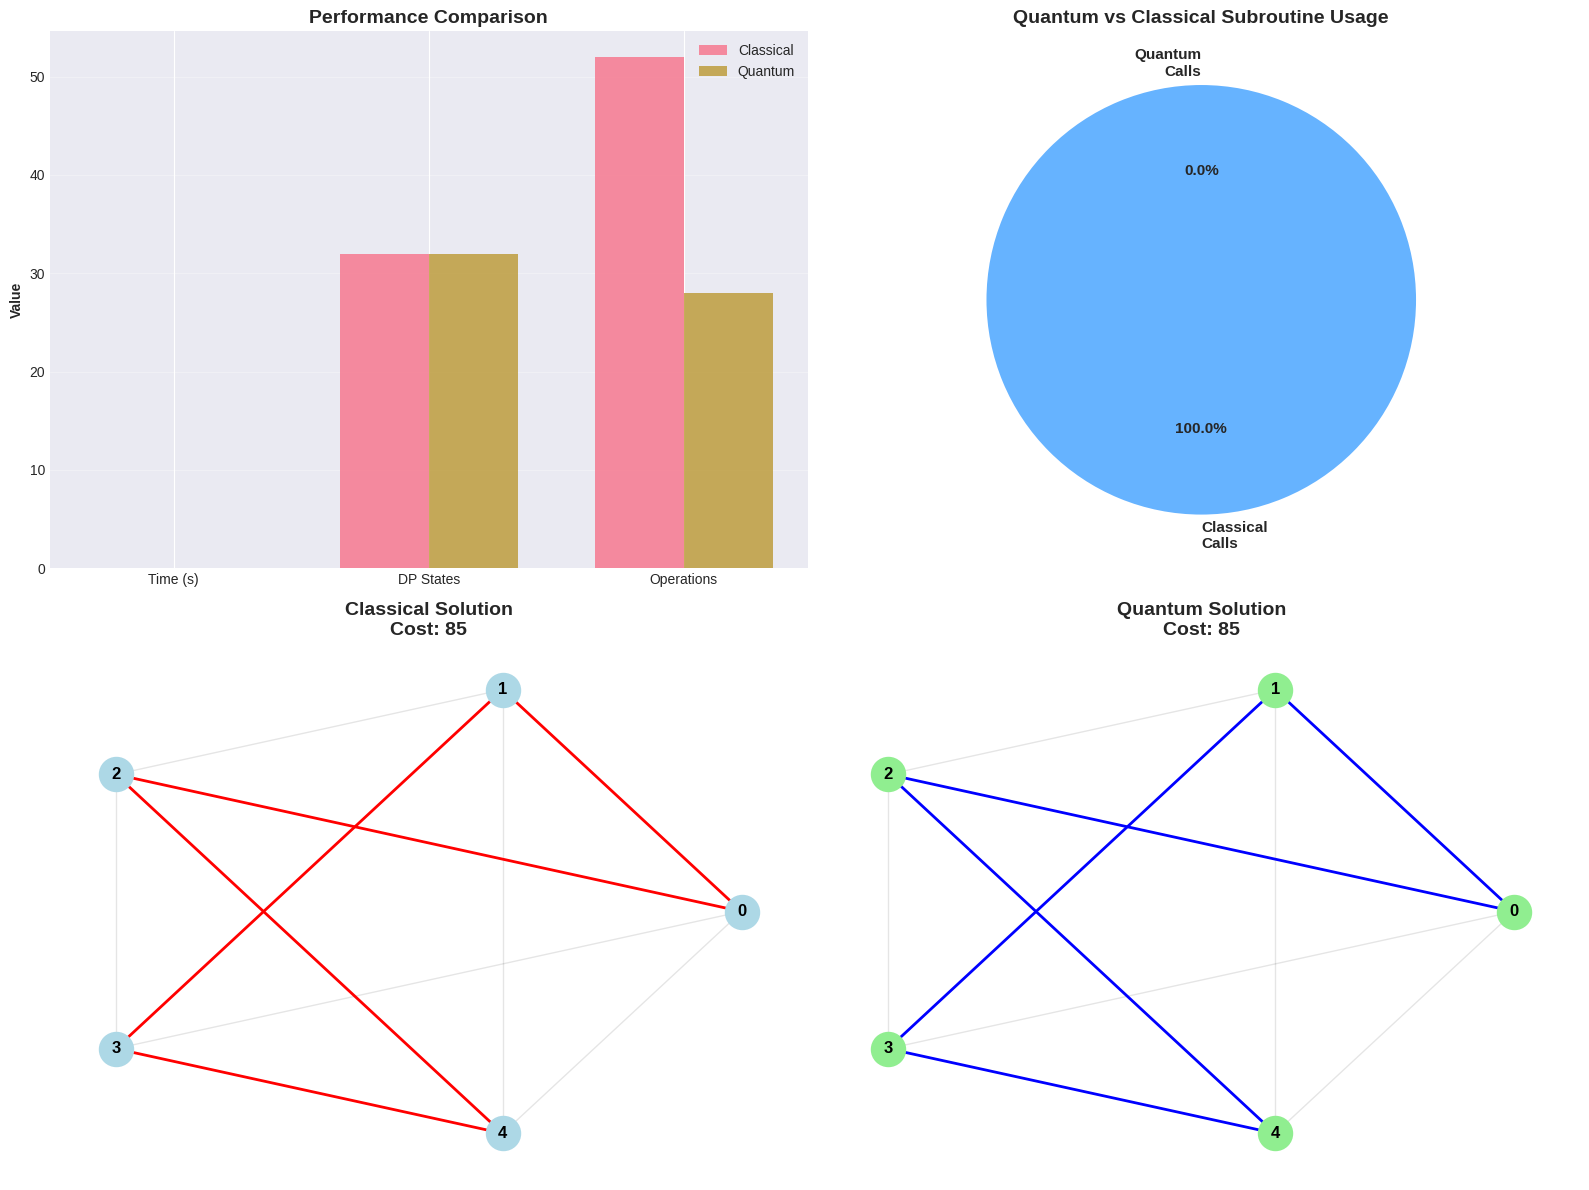


Summary:

Classical DP:
  Path: [0, 2, 4, 3, 1, 0]
  Cost: 85
  Time: 0.0003s
  Operations: 52

Quantum-Enhanced DP:
  Path: [0, 2, 4, 3, 1, 0]
  Cost: 85
  Time: 0.0005s
  Quantum calls: 0
  Classical calls: 28

Verification:
  ✓ Both methods found the same optimal solution!


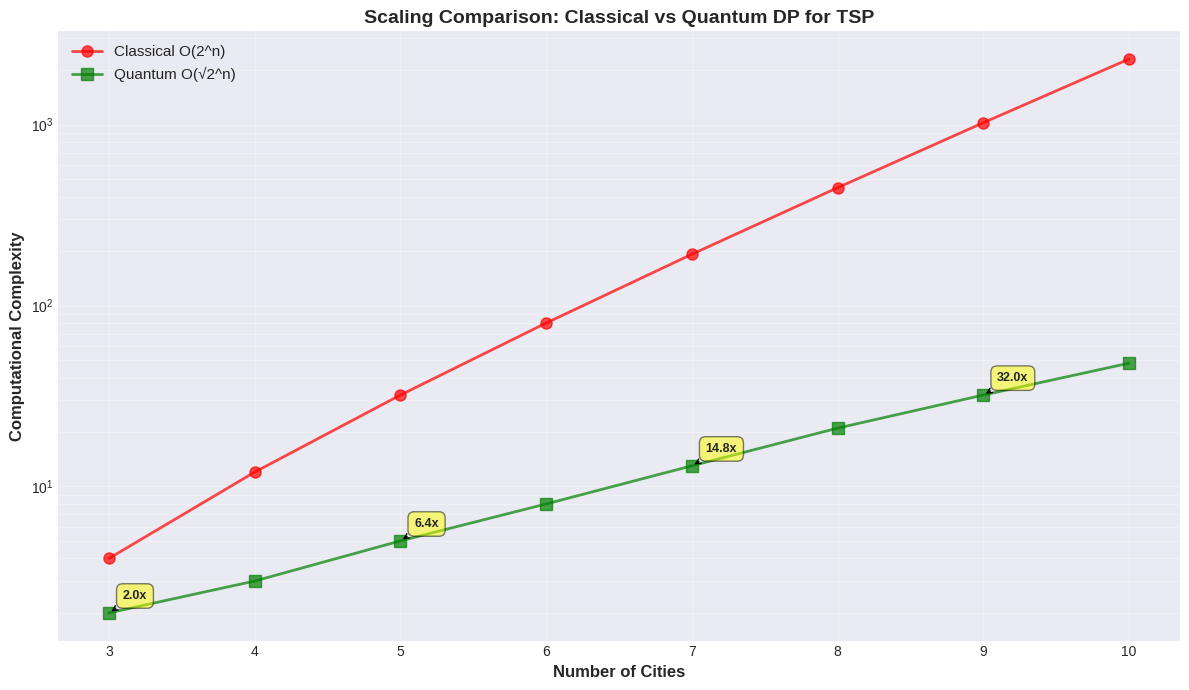

3          4               2               2.00x
4          12              3               4.00x
5          32              5               6.40x
6          80              8               10.00x
7          192             13              14.77x
8          448             21              21.33x
9          1,024           32              32.00x
10         2,304           48              48.00x


In [ ]:
# main

# define
cost_matrix = [
    [0, 10, 15, 20, 25],
    [10, 0, 35, 25, 30],
    [15, 35, 0, 30, 20],
    [20, 25, 30, 0, 15],
    [25, 30, 20, 15, 0]
]

qmf = QuantumMinimumFinder(shots=2048)
test_costs = [15, 8, 23, 8, 42, 16, 8, 30]
min_idx, qmf_stats = qmf.find_minimum(lambda i: test_costs[i], len(test_costs))

# visualize
visualize_graph(cost_matrix, "TSP Problem - Complete Graph")
visualize_dp_states(len(cost_matrix))
visualize_quantum_circuit()
visualize_qmf_results(qmf_stats)

# solve & compare
classical_solver = ClassicalTSPSolver(cost_matrix)
classical_result = classical_solver.solve()

visualize_tour(cost_matrix, classical_result['path'], "Classical DP Solution", classical_result['cost'])

quantum_solver = QuantumTSPSolver(cost_matrix, use_quantum_threshold=3)
quantum_result = quantum_solver.solve()

visualize_tour(cost_matrix, quantum_result['path'], "Quantum-Enhanced DP Solution", quantum_result['cost'])

compare_results(classical_result, quantum_result, cost_matrix)

anim = animate_tour(cost_matrix, classical_result['path'], interval=1000)
display(HTML(anim.to_jshtml()))

# analysis
sizes = range(3, 11)
classical_complexity = []
quantum_complexity = []

for n in sizes:
    states = sum(math.comb(n-1, k) * k for k in range(1, n))
    classical_complexity.append(states)
    quantum_complexity.append(int(np.sqrt(states)))

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(sizes, classical_complexity, 'o-', linewidth=2, markersize=8, label='Classical O(2^n)', color='red', alpha=0.7)
ax.plot(sizes, quantum_complexity, 's-', linewidth=2, markersize=8, label='Quantum O(√2^n)', color='green', alpha=0.7)
ax.set_xlabel('Number of Cities', fontsize=12, fontweight='bold')
ax.set_ylabel('Computational Complexity', fontsize=12, fontweight='bold')
ax.set_title('Scaling Comparison: Classical vs Quantum DP for TSP', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

for i, n in enumerate(sizes):
    if i % 2 == 0:
        speedup = classical_complexity[i] / quantum_complexity[i]
        ax.annotate(f'{speedup:.1f}x',
                   xy=(n, quantum_complexity[i]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

for i, n in enumerate(sizes):
    speedup = classical_complexity[i] / quantum_complexity[i]
    print(f"{n:<10} {classical_complexity[i]:<15,} {quantum_complexity[i]:<15,} {speedup:.2f}x")